#### Agustin Lew
## Asignment 1 - Data Curation

Imports the necessary libraries to perform data gathering and analysis

In [1]:
import json
import numpy as np
import requests
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Data Acquisition

First, the url bases that we will use in our API calls are set. Then the parameters for the different API calls are chosen depending on the type of API and access type.

In [2]:
# sets the url for the wikimedia api call for legacy pagecounts and pageviews 
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:

# sets the parameters for legacy pagecounts for desktop and mobile access
params_legacy_desktop = {"project" : "en.wikipedia.org",
                         "access-site" : "desktop-site",
                         "granularity" : "monthly",
                         "start" : "2007120100",
                         "end" : "2016080100"
                         }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                         "access-site" : "mobile-site",
                         "granularity" : "monthly",
                         "start" : "2007120100",
                         "end" : "2016080100"
                         }

In [4]:
## sets the parameters for pageviews for desktop, mobile-app and mobile-web access
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                            "access" : "desktop",
                            "agent" : "user",
                            "granularity" : "monthly",
                            "start" : "2015070100",
                            "end" : '2019100100'
                            }

params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                               "access" : "mobile-app",
                               "agent" : "user",
                               "granularity" : "monthly",
                               "start" : "2015070100",
                               "end" : '2019100100'
                               }

params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                               "access" : "mobile-web",
                               "agent" : "user",
                               "granularity" : "monthly",
                               "start" : "2015070100",
                               "end" : '2019100100'
                               }

# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/ablew',
    'From': 'ablew@uw.edu'
}

Then, function is defined for making api calls using the url bases and the parameters that will be inserted into them.

In [5]:
def api_call(endpoint, parameters):
    """
    makes api calls using the endpoint url and the parameters
    params:
    endpoint str
    parameters dict
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

The api_call function is used to obtain the data in .json format.

In [6]:
# obtains data from api for legacy pagecounts for both desktop and mobile access
monthly_legacy_desktop = api_call(endpoint_legacy, params_legacy_desktop)
monthly_legacy_mobile = api_call(endpoint_legacy, params_legacy_mobile)

In [7]:
# obtains data from api for pageviews for desktop, mobile app and mobile web access
monthly_pageviews_desktop = api_call(endpoint_pageviews, params_pageviews_desktop)
monthly_pageviews_mobile_app = api_call(endpoint_pageviews, params_pageviews_mobile_app)
monthly_pageviews_mobile_web = api_call(endpoint_pageviews, params_pageviews_mobile_web)

The data is stored in .json files with the proper file names.

In [8]:
# saves data in .json files
with open('pagecounts_desktop-site_200712-201608.json', 'w') as outfile:
    json.dump(monthly_legacy_desktop, outfile)
with open('pagecounts_mobile-site_200712-201608.json', 'w') as outfile:
    json.dump(monthly_legacy_desktop, outfile)
with open('pageviews_desktop_201507-201910.json', 'w') as outfile:
    json.dump(monthly_legacy_desktop, outfile)
with open('pageviews_mobile-app_201507-201910.json', 'w') as outfile:
    json.dump(monthly_legacy_desktop, outfile)
with open('pageviews_mobile-web_201507-201910.json', 'w') as outfile:
    json.dump(monthly_legacy_desktop, outfile)

### 2. Data Processing

Pandas dataframes are created for each API/access-type using json_normalize().

In [9]:
# creates dataframes for legacy desktop views and for legacy mobile pagecounts
df_lg_desktop = json_normalize(monthly_legacy_desktop['items'])[['timestamp', 'count']]
df_lg_mobile = json_normalize(monthly_legacy_mobile['items'])[['timestamp', 'count']]

In [10]:
# creates dataframes for desktop, mobile-app and mobile-web pageviews 
df_pv_desktop = json_normalize(monthly_pageviews_desktop['items'])[['timestamp', 'views']]
df_pv_mobile_app = json_normalize(monthly_pageviews_mobile_app['items'])[['timestamp', 'views']]
df_pv_mobile_web = json_normalize(monthly_pageviews_mobile_web['items'])[['timestamp', 'views']]

A new dataframe containing data for total mobile views is created by combining the number of views using the mobile app and the mobile web browser.

In [11]:
# creates a new dataframe based on mobile-app and mobile-web to obtain total mobile views
df_pv_total_mobile = pd.DataFrame() 
df_pv_total_mobile['timestamp'] = df_pv_mobile_app['timestamp']
df_pv_total_mobile['views'] = df_pv_mobile_app['views'] + df_pv_mobile_web['views']

In [12]:
df_pv_total_mobile.head()

,timestamp,views
0,2015070100,3288755294
1,2015080100,3302333038
2,2015090100,3170203333
3,2015100100,3268499132
4,2015110100,3236601070


The dataframes are joined one by one on the timestamp column, and replaces the missing values with zeros.

In [13]:
# joins all four dataframes on the timestamp column
df_merged = pd.merge(df_lg_desktop, df_lg_mobile, on='timestamp', how='outer')
df_merged = pd.merge(df_merged, df_pv_desktop, on='timestamp', how='outer')
df_merged = pd.merge(df_merged, df_pv_total_mobile, on='timestamp', how='outer')

# fills NaNs with 0s
df_merged = df_merged.fillna(0)

In [14]:
df_merged.head()

,timestamp,count_x,count_y,views_x,views_y
0,2007120100,2.998332e+09,0.0,0.0,0.0
1,2008010100,4.930903e+09,0.0,0.0,0.0
2,2008020100,4.818394e+09,0.0,0.0,0.0
3,2008030100,4.955406e+09,0.0,0.0,0.0
4,2008040100,5.159162e+09,0.0,0.0,0.0


The final dataframe is created, containing the necessary columns as stipulated by the assignment instructions.

In [15]:
#creates the final dataframe with all the relevant data, slicing the timestamp column into year and month
df_final = pd.DataFrame()
df_final['year'] = df_merged['timestamp'].str.slice(0, 4) 
df_final['month'] = df_merged['timestamp'].str.slice(4, 6)
df_final['pagecount_all_views'] = df_merged['count_x'] + df_merged['count_y']
df_final['pagecount_desktop_views'] = df_merged['count_x']
df_final['pagecount_mobile_views'] = df_merged['count_y']
df_final['pageview_all_views'] = df_merged['views_x'] + df_merged['views_y']
df_final['pageview_desktop_views'] = df_merged['views_x']
df_final['pageview_mobile_views'] = df_merged['views_y']

In [16]:
df_final.head()

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.0,0.0,0.0
1,2008,01,4.930903e+09,4.930903e+09,0.0,0.0,0.0,0.0
2,2008,02,4.818394e+09,4.818394e+09,0.0,0.0,0.0,0.0
3,2008,03,4.955406e+09,4.955406e+09,0.0,0.0,0.0,0.0
4,2008,04,5.159162e+09,5.159162e+09,0.0,0.0,0.0,0.0


The final dataframe is saved as a .csv file.

In [19]:
df_final.to_csv('en-wikipedia_traffic_200712-201809.csv', index=False)

### 3. Data Analysis

The zero values are replaced with NaNs to provide a clearer visualization and to show when each method for data collection starts and ends.
The time series for each dataframe is plotted in a single visualization, and various graph elements are added and formatted, such the the title, the labels, the grid, and the legend.
A .png image of the plot is also saved before showing the visualization.

In [20]:
# replaces all 0's with Nans so that they don't appear in the visualization
df_final.replace(0, np.nan, inplace=True)

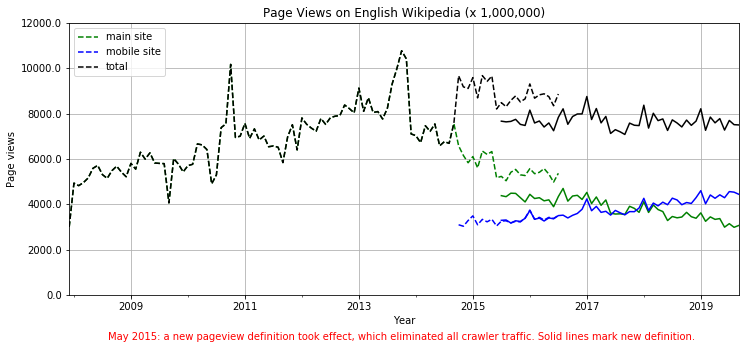

In [24]:
# creates a time series graph with the different types of apis and access types
df_final.set_index(pd.to_datetime(df_final[['year','month']].assign(day=1)))['pagecount_desktop_views'].plot(color='green', linestyle='--', figsize=(12,5))
df_final.set_index(pd.to_datetime(df_final[['year','month']].assign(day=1)))['pagecount_mobile_views'].plot(color='blue', linestyle='--')
df_final.set_index(pd.to_datetime(df_final[['year','month']].assign(day=1)))['pagecount_all_views'].plot(color='black', linestyle='--')
df_final.set_index(pd.to_datetime(df_final[['year','month']].assign(day=1)))['pageview_desktop_views'].plot(color='green', linestyle='-')
df_final.set_index(pd.to_datetime(df_final[['year','month']].assign(day=1)))['pageview_mobile_views'].plot(color='blue', linestyle='-')
df_final.set_index(pd.to_datetime(df_final[['year','month']].assign(day=1)))['pageview_all_views'].plot(color='black', linestyle='-')

# adds title, axis labels, yticks, grid, legend and footnote
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.xlabel('Year')
plt.ylabel('Page views')
#yticks are converted so it shows numbers x 1,000,000
max_views = max(df_final['pagecount_all_views'])
plt.yticks(ticks=np.arange(0, max_views + 2000000000, 2000000000), labels=np.arange(0, max_views/1000000 + 2000, 2000))
plt.grid()
plt.legend(('main site', 'mobile site', 'total'), loc='upper left')
plt.figtext(0.85, 0, 'May 2015: a new pageview definition took effect, which eliminated all crawler traffic. Solid lines mark new definition.', horizontalalignment='right', color='red')
plt.savefig('plot.png')
plt.show()